In [1]:
import sqlite3
import os
from skimage.feature import register_translation
import pandas as pd
from astropy.io import fits
import matplotlib.pyplot as plt
from datetime import datetime as dt
import numpy as np

In [2]:
# import LAM library for logbook, data analysis...
from pfs.sacFileHandling import *

In [3]:
imgPath = '/home/pfs/shared/Pictures/SM1'

In [4]:
smId = 1

In [5]:
def correlate(reference, image):
    return register_translation(reference, image, 100)

    
def sacShift(filelist, duplicate):
    __, reference = stackedImage(filelist, 0, duplicate=duplicate)
    res = []
    
    for i in range(len(filelist)//duplicate):
        hdr, image = stackedImage(filelist, i, duplicate=duplicate)
        ccdPos = round(hdr['ait.sac.ccd.position'], 1)
        pentaPos= round(hdr['ait.sac.penta.position'], 1)

        shift, error, diffphase = correlate(reference=reference, image=image)
        res.append((ccdPos,pentaPos,shift[0], shift[1]))
        
    return pd.DataFrame(data=res, columns=['ccdPosition', 'pentaPosition', 'shift_x', 'shift_y'])

## Data required : 
To be able to find the right focus, some data acquisition is required.

you need to use ics_spsaitActor to perform your sequence

example : <b>sac align exptime=1.0 focus=0 lowBound=-450 upBound=450 nbPosition=10 duplicate=3</b>

-450 : 450 is the range of the pentaprism linear stage

focus is the position of the ccd linear stage

the goal here is to take several sequences for difference focus value, here we have taken data for [0,2,4,6,8]


## Input Parameters : 
The only parameters needed is the experimentIds that match your data acquisition sequence

In [6]:
experimentStart = 27 #the first experimentId is 12
experimentEnd = 35    #the last experimentId is 16

In [7]:
dfs = []

for experimentId in range(experimentStart, experimentEnd+1):
    visitStart, visitEnd = Logbook.visitRange(experimentId=experimentId)
    duplicate = int(Logbook.getParameter(experimentId=experimentId, param='duplicate'))
    
    filelist = constructFilelist(visitStart=visitStart, visitEnd=visitEnd)
    dfs.append(sacShift(filelist=filelist, duplicate=duplicate))

cube = pd.concat(dfs)

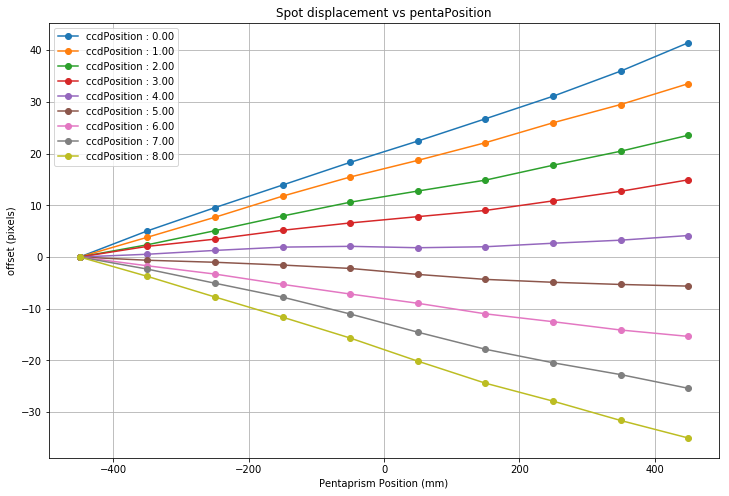

In [8]:
plt.figure(figsize=(12,8))
plt.xlabel('Pentaprism Position (mm)')
plt.ylabel('offset (pixels)')


for ccdPosition, df in cube.groupby('ccdPosition'):
    plt.plot(df['pentaPosition'], df['shift_x'], 'o-', label='ccdPosition : %.2f'%ccdPosition)
    
plt.title('Spot displacement vs pentaPosition')
plt.grid()
plt.legend()

if False:
    plt.savefig(os.path.join(imgPath, 'SM1_SACALIGN_EXP%i-%i_SPOT_DISPLACEMENT.png'%(experimentStart, experimentEnd)))

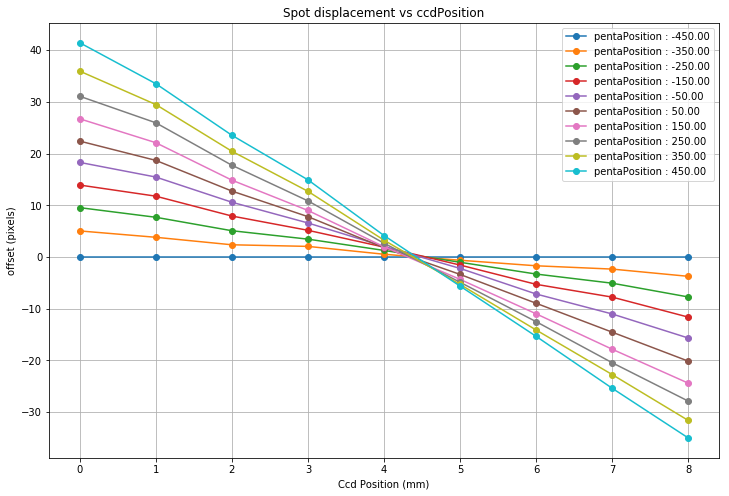

In [9]:
plt.figure(figsize=(12,8))
plt.xlabel('Ccd Position (mm)')
plt.ylabel('offset (pixels)')


for pentaPosition, df in cube.groupby('pentaPosition'):
    plt.plot(df['ccdPosition'], df['shift_x'], 'o-', label='pentaPosition : %.2f'%pentaPosition)
    
plt.title('Spot displacement vs ccdPosition')
plt.grid()
plt.legend()

if False:
    plt.savefig(os.path.join(imgPath, 'SM1_SACALIGN_EXP%i-%i_SPOT_DISPLACEMENT.png'%(experimentStart, experimentEnd)))

In [10]:
data = []
for ccdPosition, df in cube.groupby('ccdPosition'):
    [slope, offset] = np.polyfit(df['pentaPosition'], df['shift_x'], deg=1)
    data.append((ccdPosition, slope))
    
df = pd.DataFrame(data=data, columns=['ccdPosition', 'slope'])

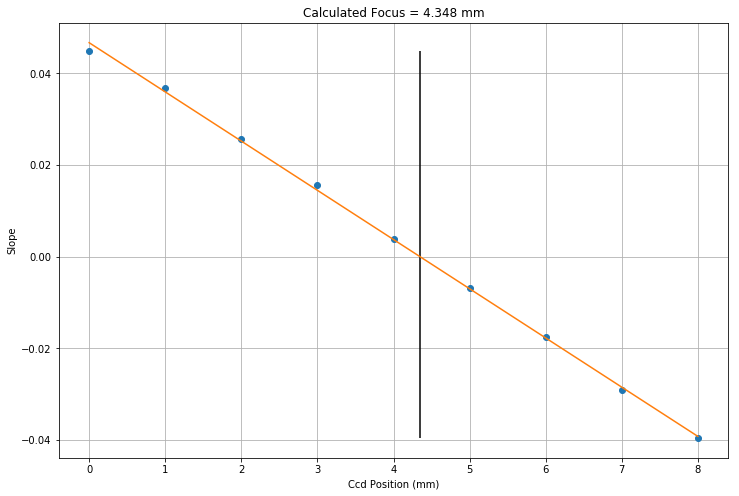

In [11]:
x = np.arange(np.min(df['ccdPosition']), np.max(df['ccdPosition'])+0.01, 0.01)
popt = np.polyfit(df['ccdPosition'], df['slope'], deg=1)

plt.figure(figsize=(12,8))
plt.xlabel('Ccd Position (mm)')
plt.ylabel('Slope')

plt.plot(df['ccdPosition'], df['slope'], 'o')
plt.plot(x, np.polyval(popt, x), '-')

calc_focus = -popt[1]/popt[0]
plt.vlines(x=calc_focus, ymin=np.min(df['slope']), ymax=np.max(df['slope']))
plt.title('Calculated Focus = %.3f mm'%calc_focus)
plt.grid()

if False:
    plt.savefig(os.path.join(imgPath, 'SM1_SACALIGN_EXP%i-%i_CALC_FOCUS.png'%(experimentStart, experimentEnd)))

In [12]:
f = 1497.
pix_size = 4.539e-3
foc = []

for ccdPosition, df in cube.groupby('ccdPosition'):
    foc.append(ccdPosition+df.shift_x.iloc[-1] * pix_size * f / 90.)

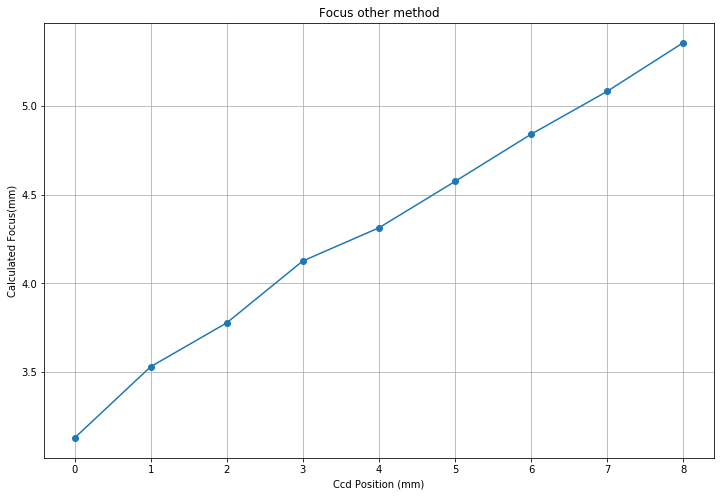

In [13]:
plt.figure(figsize=(12,8))
plt.xlabel('Ccd Position (mm)')
plt.ylabel('Calculated Focus(mm)')
plt.title('Focus other method')

plt.plot(foc, 'o-')
plt.grid()